<a href="https://colab.research.google.com/github/shahma123/codsoft/blob/main/sales_prediction/%20sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q scikit-learn joblib matplotlib pandas

import os, math
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import joblib
import re


from google.colab import files
uploaded = files.upload()
fname = next(iter(uploaded.keys()))
df = pd.read_csv(fname)

Saving advertising.csv to advertising.csv


In [3]:
print("Shape:", df.shape)
print(df.columns.tolist())
display(df.head())
print(df.describe(include='all'))

Shape: (200, 4)
['TV', 'Radio', 'Newspaper', 'Sales']


,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,12.0
3,151.5,41.3,58.5,16.5
4,180.8,10.8,58.4,17.9


               TV       Radio   Newspaper       Sales
count  200.000000  200.000000  200.000000  200.000000
mean   147.042500   23.264000   30.554000   15.130500
std     85.854236   14.846809   21.778621    5.283892
min      0.700000    0.000000    0.300000    1.600000
25%     74.375000    9.975000   12.750000   11.000000
50%    149.750000   22.900000   25.750000   16.000000
75%    218.825000   36.525000   45.100000   19.050000
max    296.400000   49.600000  114.000000   27.000000


In [4]:
feature_cols = [c for c in df.columns if c.lower() in ['tv','radio','newspaper'] or c.lower() in ['tv','radio','newspaper']]
if not feature_cols:

    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    if len(nums) >= 2:
        feature_cols = nums[:-1]
    else:
        raise RuntimeError("Can't auto-detect features. Tell me which columns to use.")


possible_targets = [c for c in df.columns if any(k in c.lower() for k in ['sales','amount','revenue','units','target'])]
if possible_targets:
    target = possible_targets[0]
else:

    nums = df.select_dtypes(include=[np.number]).columns.tolist()
    target = nums[-1]

print("Features:", feature_cols, "  Target:", target)

for c in feature_cols + [target]:
    if df[c].dtype == object:
        df[c] = df[c].astype(str).str.replace(r'[\$,]', '', regex=True)
        df[c] = pd.to_numeric(df[c], errors='coerce')

df = df.dropna(subset=[target])
print("After dropna rows:", df.shape[0])

Features: ['TV', 'Radio', 'Newspaper']   Target: Sales
After dropna rows: 200


In [5]:
X = df[feature_cols]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pre = ColumnTransformer([("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), feature_cols)])

lr_pipeline = Pipeline([("prep", pre), ("lr", LinearRegression())])
rf_pipeline = Pipeline([("prep", pre), ("rf", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=2))])

print("Training Linear Regression...")
lr_pipeline.fit(X_train, y_train)
print("Training RandomForest (may take a few seconds)...")
rf_pipeline.fit(X_train, y_train)

Training Linear Regression...
Training RandomForest (may take a few seconds)...


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TV', 'Radio',
                                                   'Newspaper'])])),
                ('rf', RandomForestRegressor(n_jobs=2, random_state=42))])

In [6]:
def eval_model(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {"rmse":rmse,"mae":mae,"r2":r2, "y_pred": y_pred}

from sklearn.metrics import mean_absolute_error
res_lr = eval_model(lr_pipeline, X_test, y_test)
res_rf = eval_model(rf_pipeline, X_test, y_test)

print("Linear Regression:", res_lr)
print("Random Forest:", res_rf)

Linear Regression: {'rmse': 1.7052146229349234, 'mae': 1.2748262109549349, 'r2': 0.9059011844150825, 'y_pred': array([17.0347724 , 20.40974033, 23.72398873,  9.27278518, 21.68271879,
       12.56940161, 21.08119452,  8.69035045, 17.23701254, 16.66657475,
        8.92396497,  8.4817344 , 18.2075123 ,  8.06750728, 12.64550975,
       14.93162809,  8.12814594, 17.89876565, 11.00880637, 20.47832788,
       20.80631846, 12.59883297, 10.9051829 , 22.38854775,  9.41796094,
        7.92506736, 20.83908497, 13.81520938, 10.77080925,  7.92682509,
       15.95947357, 10.63490851, 20.80292008, 10.43434164, 21.5784752 ,
       21.18364487, 12.12821771, 22.80953262, 12.60992766,  6.46441252])}
Random Forest: {'rmse': 1.1986824224956334, 'mae': 0.9171499999999991, 'r2': 0.9535019934565436, 'y_pred': array([17.299, 22.482, 19.77 ,  6.784, 22.961, 13.471, 22.595,  9.579,
       16.887, 16.793,  7.499, 10.327, 17.345,  5.132, 11.5  , 16.902,
        6.549, 17.788, 11.632, 19.766, 19.965, 13.134, 10.018,

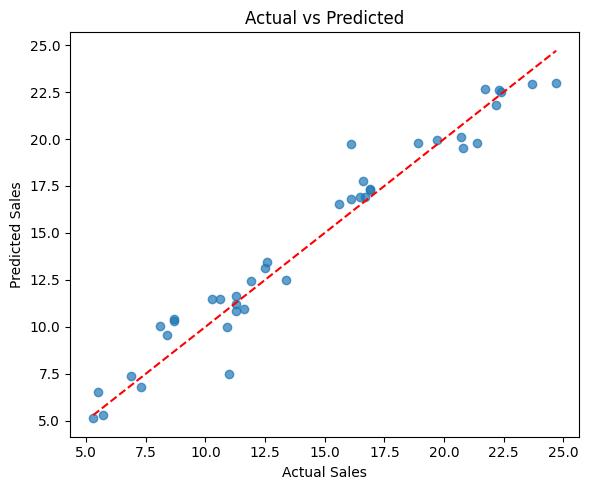

In [7]:
best = lr_pipeline if res_lr['rmse'] <= res_rf['rmse'] else rf_pipeline
y_pred = best.predict(X_test)

plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted")
plt.tight_layout()
plt.show()